In [1]:
import torch
#import torchvision

from torch.utils.data import DataLoader

import os
from PIL import Image

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score as accuracy

from tqdm.auto import tqdm

colors = sns.color_palette("rocket")
colors

[(0.20973515, 0.09747934, 0.24238489),
 (0.43860848, 0.12177004, 0.34119475),
 (0.67824099, 0.09192342, 0.3504148),
 (0.8833417, 0.19830556, 0.26014181),
 (0.95381595, 0.46373781, 0.31769923),
 (0.96516917, 0.70776351, 0.5606593)]

In [2]:
class Prior_Data_Analys:
  def __init__(self,df):
    self.df = df


  def shape(self):
    n_samples,n_columns = self.df.shape
    print(f'Number of samples in Data Set: {n_samples}')
    print(f'Number of columns: {n_columns}')

    return n_samples,n_columns


  def unique_columns(self):
    columns = self.df.columns
    print(f'Unique columns:\n')

    for column_idx,column in enumerate(columns):
      print(f'Column {column_idx + 1}: {column}')

    return columns


  def columns_dtypes(self):
    dtypes = self.df.dtypes
    print(f'Dtypes:\n\n {dtypes}')

    return dtypes


  def categorical_features(self):
    print(f'Categorical features:\n')
    categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']

    for feature in categorical_feats:
      print(f'* {feature}')

    return np.array(categorical_feats)


  def numerical_features(self):
    print(f'Numerical features: \n')

    numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
    for feature in numerical_feats:
      print(f'* {feature}')

    return np.array(numerical_feats)


  def group_by(self,feature):
    categorical = self.categorical_features()

    if feature in categorical:
      return self.df.groupby([feature]).count()

    else:
      return self.df.groupby([feature]).describe()


  def count_NA(self):
    print(f'Amout of Nans per class:')
    return self.df.isna().sum()


  def duplicates(self):
    print(f'Amount of duplicates: {self.df.duplicated().sum()}')

  def item(self,index):
    print(f'Object number: {index}')

    return self.df.iloc[index]

  def unique_values(self,feature):
    data = self.df[feature]

    values = data.values
    unique_values = np.unique(values)
    print(f'Unique values of {feature}: {unique_values}')

    return unique_values

In [3]:
class Distribution:
  def __init__(self,df,target_feature):
    self.df = df
    self.target_feature = target_feature
    self._eda = Prior_Data_Analys(self.df)


  def distribution_of_target_feature(self):
    for visualization in range(2):
      plt.figure(figsize = (10,10))
      plt.subplot(2,1,visualization + 1)
      if visualization == 0:
        sns.histplot(data = self.df,x = self.target_feature,color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()

      else:
        sns.boxplot(x = self.df[self.target_feature],color = colors[3])
        plt.title(f'Distribution of Target feature: {self.target_feature}')
        plt.show()


  def distribution_of_numerical_features(self):
    numerical_features = self._eda.numerical_features()

    for feature_idx,feature in enumerate(numerical_features):
      plt.figure(figsize = (15,15))
      plt.subplot(len(numerical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.histplot(data = self.df,x = feature,color = colors[1])
      plt.title(f'Distibution of {feature}')
      plt.tight_layout
      plt.show()


  def distribution_of_categorical_features(self,top_k = 5):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      values = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).values[:top_k]
      labels = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False).index[:top_k]

      data_dict = {'Labels': labels, 'Values': values}
      data = pd.DataFrame(data_dict)

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.barplot(data = data,y = 'Labels',x = 'Values',color = colors[-1])
      plt.title(f'Top {top_k} {feature} by count')

    plt.tight_layout()
    plt.show()

  def relation_numerical_feats_to_target_feat(self):
    numerical_features = self._eda.numerical_features()

    data = self.df[numerical_features]
    corr = data.corr()

    return sns.heatmap(corr,annot = True, cmap = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True))

  def relation_categorical_feats_to_target_feat(self,top_k = 3):
    categorical_features = self._eda.categorical_features()
    plt.figure(figsize = (20,20))

    for feature_idx,feature in enumerate(categorical_features):

      feats = self._eda.group_by(feature)[self.target_feature].sort_values(ascending = False)[:top_k].index

      data = self.df
      data = data[data[feature].isin(feats)]

      plt.subplot(len(categorical_features) // 2 + 1 , 2 , feature_idx + 1)
      sns.stripplot(data = data, x = feature, y = self.target_feature,hue = feature)
      plt.title(f'Relation between {feature} (top {top_k}) & {self.target_feature}')

    plt.tight_layout()
    plt.show()

In [4]:
class Image_Df:        
    def _data_from_path(self,path):
        file_names = None
        
        for _, _,filenames in os.walk(path):
            file_names = filenames
            
        labels = [0 if file_name.split('_')[0] == 'notsmoking' else 1 for file_name in file_names]
        
        return np.array(file_names),np.array(labels)

        
    def create_df(self,path):
        images,labels = self._data_from_path(path)
        
        df_dict = {'Image': images, 'Label': labels}
        df = pd.DataFrame(df_dict)
        
        return df

In [5]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self,df,folder_path,transform = None):
        super().__init__()
        self.df = df
        self.folder_path = folder_path
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        image_path = self.df.iloc[index]['Image']
        image = Image.open(os.path.join(self.folder_path,image_path))
        
        label = self.df.iloc[index]['Label']
        
        if self.transform != None:
            image = self.transform(image)
        
        return image,label

In [6]:
class CNN(torch.nn.Module):
    def __init__(self,in_channels,n_classes):
        super().__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        
        self.conv_1_1 = torch.nn.Conv2d(in_channels = in_channels,out_channels = 32,kernel_size = 3)
        self.conv_1_2 = torch.nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3)
        self.conv_2_1 = torch.nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3)
        self.conv_2_2 = torch.nn.Conv2d(in_channels = 32,out_channels = 32,kernel_size = 3)
        
        self.max_pool = torch.nn.MaxPool2d(kernel_size = 5,stride = 5)
        self.relu = torch.nn.ReLU()
        
        self.linear_1 = torch.nn.Linear(in_features = 1568 , out_features = 128)
        self.linear_2 = torch.nn.Linear(in_features = 128 ,out_features = n_classes)
        self.softmax = torch.nn.Softmax(1)
        
    def forward(self,X):
        X = self.conv_1_1(X)
        X = self.relu(X)
        
        X = self.conv_1_2(X)
        X = self.relu(X)
        X = self.max_pool(X)

        
        X = self.conv_2_1(X)
        X = self.relu(X)
        
        X = self.conv_2_2(X)
        X = self.relu(X)
        X = self.max_pool(X)
        
        X = torch.flatten(X,1)
        
        X = self.linear_1(X)
        X = self.relu(X)
        
        X = self.linear_2(X)
        
        return X

In [7]:
class Train_Model:
    def __init__(self,model,optimizer,loss_function,epochs = 10):
        self.model = model
        self.optimizer = optimizer
        self.loss_function  = loss_function
        self.epochs = epochs
    
    def fit(self,train_data_batched):
        self.model.train()
        train_batch_loss = 0
        train_batch_acc = 0
        
        for epoch in tqdm(range(self.epochs + 1)):
            for batch,(X_train,y_train) in tqdm(enumerate(train_data_batched)):
                train_prediction = self.model(X_train)
                train_labels = torch.argmax(train_prediction,1)
                
                train_loss = self.loss_function(train_prediction,y_train)
                train_acc = accuracy(y_train,train_labels)
                
                train_batch_loss += train_loss
                train_batch_acc += train_acc
                
                self.optimizer.zero_grad()
                train_loss.backward()
                self.optimizer.step()
                
            train_batch_loss /= len(train_data_batched)
            train_batch_acc /= len(train_data_batched)
            
            if epoch % 1 == 0:
                print(f'Epoch: {epoch} | Train Loss: {train_batch_loss} | Train Accuracy: {train_batch_acc}')
    
    def eval(self,test_data_batched):
        self.model.eval()
        test_batch_loss = 0
        test_batch_acc = 0
        
        for batch,(X_test,y_test) in enumerate(test_data_batched):
            test_prediction = self.model(X_test)
            test_labels = torch.argmax(test_prediction,1)
            
            test_loss = self.loss_function(test_prediction,y_test)
            test_acc = accuracy(y_test,test_labels)
            
            test_batch_loss += test_loss
            test_batch_acc += test_acc
            
        test_batch_loss /= len(test_data_batched)
        test_batch_acc /= len(test_data_batched)
        
        print(f'Test Loss: {test_batch_loss} | Test Accuracy: {test_batch_acc}')

In [8]:
def Classifie(model,image_path):
    transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (200,200)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
    
    image = Image.open(image_path)
    image = transforms(image)
    
    prediction = model(image.unsqueeze(0))
    model_confidence = torch.max(prediction).item()
    
    label = torch.argmax(prediction).item()
    label_class = 'notsmoking' if label == 0 else 'smoking'

    
    return label_class,model_confidence

In [9]:
train_path = '/Users/nazarlenisin/Desktop/Image Classification/Training/Training'
test_path = '/Users/nazarlenisin/Desktop/Image Classification/Testing/Testing'

In [10]:
train_df = Image_Df().create_df(train_path)
test_df = Image_Df().create_df(test_path)
train_df

,Image,Label
0,notsmoking_0098.jpg,0
1,smoking_0143.jpg,1
2,notsmoking_0067.jpg,0
3,smoking_0194.jpg,1
4,smoking_0180.jpg,1
...,...,...
711,smoking_0370.jpg,1
712,smoking_0416.jpg,1
713,notsmoking_0056.jpg,0
714,notsmoking_0042.jpg,0


In [11]:
target_feature = 'Label'

eda = Prior_Data_Analys(train_df)
data_visualization = Distribution(train_df,target_feature = target_feature)

In [12]:
eda.shape()

Number of samples in Data Set: 716
Number of columns: 2


(716, 2)

In [13]:
eda.unique_columns()

Unique columns:

Column 1: Image
Column 2: Label


Index(['Image', 'Label'], dtype='object')

In [14]:
eda.columns_dtypes()

Dtypes:

 Image    object
Label     int64
dtype: object


Image    object
Label     int64
dtype: object

In [15]:
eda.categorical_features()

Categorical features:

* Image


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_33798/2509911963.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_33798/2509911963.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  categorical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] == 'object']


array(['Image'], dtype='<U5')

In [16]:
eda.numerical_features()

Numerical features: 

* Label


/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_33798/2509911963.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']
/var/folders/k9/6y59tr5d45s1nynfg_sv5zr80000gn/T/ipykernel_33798/2509911963.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  numerical_feats = [column for column_idx,column in enumerate(self.df.columns) if self.df.dtypes[column_idx] != 'object']


array(['Label'], dtype='<U5')

In [17]:
eda.count_NA()

Amout of Nans per class:


Image    0
Label    0
dtype: int64

In [18]:
eda.duplicates()

Amount of duplicates: 0


In [19]:
eda.unique_values(target_feature)

Unique values of Label: [0 1]


array([0, 1])

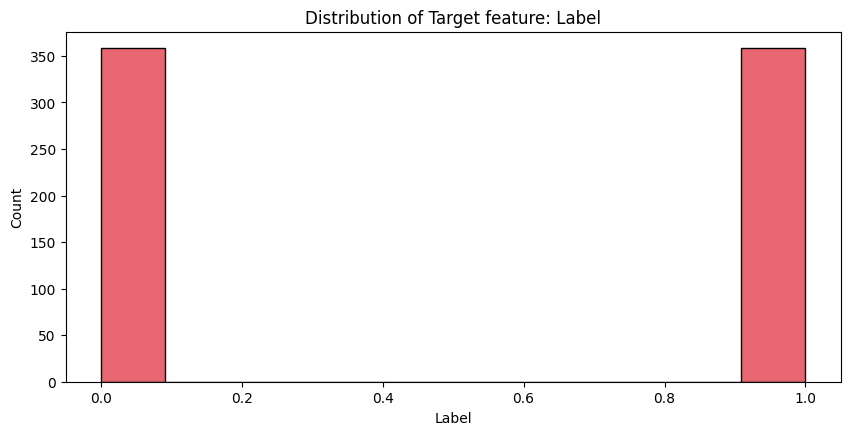

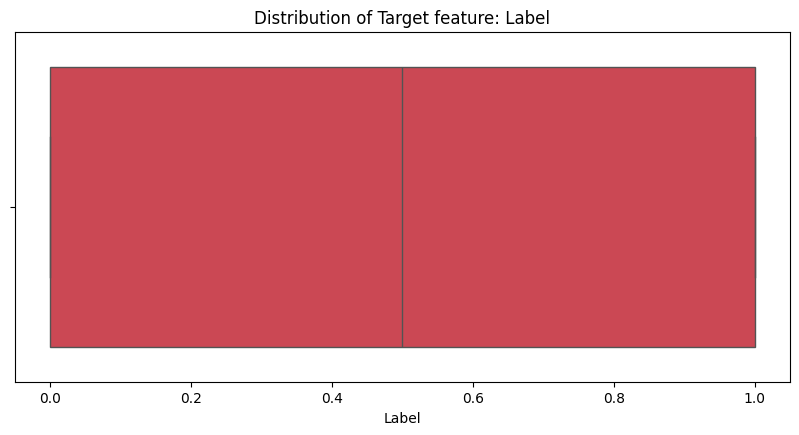

In [20]:
data_visualization.distribution_of_target_feature()

In [21]:
import torchvision
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (200,200)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_data = CustomDataset(train_df,train_path,transform = transforms)
test_data = CustomDataset(test_df,test_path,transform = transforms)

train_data_batched = DataLoader(train_data,32,shuffle = True)
test_data_batched = DataLoader(test_data,32,shuffle = False)

batched_images,batched_labels = next(iter(train_data_batched))
print(f'Example Batch from Train Dataset:')
print(f'Batched Images ({batched_images.shape}): {batched_images}')
print(f'Batched labels ({batched_labels.shape}): {batched_labels}')


Example Batch from Train Dataset:
Batched Images (torch.Size([32, 3, 200, 200])): tensor([[[[ 0.4166,  0.4166,  0.4166,  ...,  0.1426,  0.2453,  0.2624],
          [ 0.4337,  0.4337,  0.4337,  ...,  0.1426,  0.2453,  0.4508],
          [ 0.4337,  0.4337,  0.4337,  ...,  0.2282,  0.2453,  0.4337],
          ...,
          [ 2.0092,  1.9578,  1.9235,  ..., -0.0116,  0.1083,  0.0398],
          [ 1.9749,  1.9235,  1.9064,  ...,  0.0741,  0.1254, -0.0287],
          [ 1.9578,  1.9235,  1.9235,  ...,  0.1426,  0.0741, -0.0287]],

         [[ 1.1856,  1.1856,  1.1856,  ..., -0.3200, -0.2675, -0.2325],
          [ 1.2031,  1.2031,  1.2031,  ..., -0.3025, -0.3025, -0.1275],
          [ 1.2031,  1.2031,  1.2031,  ..., -0.2325, -0.2675, -0.1800],
          ...,
          [ 1.4132,  1.3606,  1.3256,  ..., -0.7927, -0.6702, -0.7402],
          [ 1.3782,  1.3256,  1.3081,  ..., -0.7052, -0.6527, -0.8102],
          [ 1.3606,  1.3256,  1.3256,  ..., -0.6352, -0.7052, -0.8102]],

         [[ 2.3088, 

In [22]:
in_channels = batched_images.shape[1]
n_classes = len(eda.unique_values(target_feature))
lr = 0.0001

model = CNN(in_channels = in_channels,n_classes = n_classes)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = lr)

Trainer = Train_Model(model,optimizer,loss_function,epochs = 30)
Trainer.fit(train_data_batched)
Trainer.eval(test_data_batched)


Unique values of Label: [0 1]


  0%|          | 0/31 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch: 0 | Train Loss: 0.6702370643615723 | Train Accuracy: 0.6757246376811594


0it [00:00, ?it/s]

Epoch: 1 | Train Loss: 0.6227527856826782 | Train Accuracy: 0.74677063642092


0it [00:00, ?it/s]

Epoch: 2 | Train Loss: 0.5757913589477539 | Train Accuracy: 0.762540752308156


0it [00:00, ?it/s]

Epoch: 3 | Train Loss: 0.5599368810653687 | Train Accuracy: 0.7623206124191951


0it [00:00, ?it/s]

Epoch: 4 | Train Loss: 0.5503154993057251 | Train Accuracy: 0.763669736771849


0it [00:00, ?it/s]

Epoch: 5 | Train Loss: 0.5564752221107483 | Train Accuracy: 0.7573878146422544


0it [00:00, ?it/s]

Epoch: 6 | Train Loss: 0.5534168481826782 | Train Accuracy: 0.7616436731003879


0it [00:00, ?it/s]

Epoch: 7 | Train Loss: 0.54542475938797 | Train Accuracy: 0.7754156669463937


0it [00:00, ?it/s]

Epoch: 8 | Train Loss: 0.5425012111663818 | Train Accuracy: 0.7796376376933215


0it [00:00, ?it/s]

Epoch: 9 | Train Loss: 0.5240119099617004 | Train Accuracy: 0.7979371436678255


0it [00:00, ?it/s]

Epoch: 10 | Train Loss: 0.5165349841117859 | Train Accuracy: 0.8105081366812097


0it [00:00, ?it/s]

Epoch: 11 | Train Loss: 0.5274546146392822 | Train Accuracy: 0.7983735421745454


0it [00:00, ?it/s]

Epoch: 12 | Train Loss: 0.5058717727661133 | Train Accuracy: 0.8041865308191831


0it [00:00, ?it/s]

Epoch: 13 | Train Loss: 0.5163252353668213 | Train Accuracy: 0.7822472404703993


0it [00:00, ?it/s]

Epoch: 14 | Train Loss: 0.4951803386211395 | Train Accuracy: 0.800767995962481


0it [00:00, ?it/s]

Epoch: 15 | Train Loss: 0.48172062635421753 | Train Accuracy: 0.815613101273731


0it [00:00, ?it/s]

Epoch: 16 | Train Loss: 0.4770652651786804 | Train Accuracy: 0.819881729040887


0it [00:00, ?it/s]

Epoch: 17 | Train Loss: 0.4736068844795227 | Train Accuracy: 0.814179640393082


0it [00:00, ?it/s]

Epoch: 18 | Train Loss: 0.45908302068710327 | Train Accuracy: 0.8288773756692644


0it [00:00, ?it/s]

Epoch: 19 | Train Loss: 0.47522640228271484 | Train Accuracy: 0.8272519148841709


0it [00:00, ?it/s]

Epoch: 20 | Train Loss: 0.44867008924484253 | Train Accuracy: 0.8425797934007611


0it [00:00, ?it/s]

Epoch: 21 | Train Loss: 0.4379549026489258 | Train Accuracy: 0.8500397011623518


0it [00:00, ?it/s]

Epoch: 22 | Train Loss: 0.4146263599395752 | Train Accuracy: 0.8634981029490878


0it [00:00, ?it/s]

Epoch: 23 | Train Loss: 0.40823736786842346 | Train Accuracy: 0.8631774537514095


0it [00:00, ?it/s]

Epoch: 24 | Train Loss: 0.40410393476486206 | Train Accuracy: 0.8622577153804961


0it [00:00, ?it/s]

Epoch: 25 | Train Loss: 0.3968982398509979 | Train Accuracy: 0.8608590311034997


0it [00:00, ?it/s]

Epoch: 26 | Train Loss: 0.3832162916660309 | Train Accuracy: 0.8848018419320363


0it [00:00, ?it/s]

Epoch: 27 | Train Loss: 0.3740411102771759 | Train Accuracy: 0.8713500800840016


0it [00:00, ?it/s]

Epoch: 28 | Train Loss: 0.3809662163257599 | Train Accuracy: 0.8789173947862609


0it [00:00, ?it/s]

Epoch: 29 | Train Loss: 0.3660737872123718 | Train Accuracy: 0.8769819157153447


0it [00:00, ?it/s]

Epoch: 30 | Train Loss: 0.3524577021598816 | Train Accuracy: 0.8868615325673338
Test Loss: 0.5919623374938965 | Test Accuracy: 0.7232142857142857


Person on the photo: notsmoking


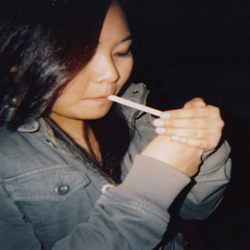

In [24]:
image_path = '/Users/nazarlenisin/Desktop/Image Classification/Testing/Testing/smoking_0496.jpg'

prediction,model_confidence = Classifie(model,image_path)
print(f'Person on the photo: {prediction}')
Image.open(image_path)
